---
# Surface Solar Radiation (SSR) - Overview
---
This notebook provides an overview of daily mean SSR distribution statistics (spread, median, skewness, kurtosis). 

The data used in this notebook are from:
- CMIP6 Climate models 
- WRDC Observations (Station of Kloten in the Canton of Zürich, Switzerland)

Copyright (c) 2023, ETH Zurich, Guillaume Senger

In [1]:
import my_functions
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from scipy.stats import skew, kurtosis
import warnings

warnings.filterwarnings("ignore", message="Warning: 'partition' will ignore the 'mask' of the MaskedArray.")
matplotlib.rcParams.update({'font.size': 24})

---
## Loading Data

We are loading the data from the models for a specific location.

In [6]:
# location      = 'Berlin'
# location      = 'Edmonton'
# location      = 'Honolulu'
# location      = 'London'
# location      = 'Madrid'
# location      = 'Manaus'
# location      = 'New Dehli'
# location      = 'Paris'
location      = 'Zurich'

rsds_models   = pickle.load(open(f'Data/rsds/{location}.pickle', 'rb')) # Load data created using the script Get_Data_Local.py

print(f'CMIP6 rsds data for the grid box containing {location}:\n')
for model_name in rsds_models:
    print(f'    {model_name}: {len(rsds_models[model_name])//365} years')

CMIP6 rsds data for the grid box containing Zurich:

    CanESM5: 1000 years
    CESM2: 1190 years
    CMCC-CM2-SR5: 500 years
    CMCC-ESM2: 500 years
    GFDL-CM4: 140 years
    GFDL-ESM4: 500 years
    NorESM2-LM: 501 years
    NorESM2-MM: 500 years
    TaiESM1: 500 years
    INM-CM4-8: 531 years
    INM-CM5-0: 1201 years
    IPSL-CM5A2-INCA: 230 years
    KIOST-ESM: 649 years


We are loading the data from the WRDC Observations from the Kloten station near Zürich.

In [7]:
file_path = '/net/o3/hymet/lferreira/WRDC_proc/glbrad6/daily/switzerland_zuerich_kloten_zuerich_kloten_daily_proc.txt'

data = np.loadtxt(file_path)

# Extract the relevant columns from the data
years        = data[:, 0]
day_of_year  = data[:, 1]
rsds_obs     = data[:, 2]
quality_flag = data[:, 3]

# For the purpose of data formatting, the 366th day of leap years is ignored to ensure the N x 365 format of the data.
valid_indices = np.where(day_of_year != 366)

years         = years[valid_indices]
day_of_year   = day_of_year[valid_indices]
rsds_obs      = rsds_obs[valid_indices]
quality_flag  = quality_flag[valid_indices]

reshaped_rsds_obs = my_functions.reshape(rsds_obs) # Reshape the the data in the format n_years x 365

n_years_obs = len(rsds_obs) // 365 

print(f'WRDC Observations ({years[0]:.0f}-{years[-1]:.0f}) for the Kloten station: {len(rsds_obs)/365:.0f} years\n')

# Print the quality of the data
print(f'Observations quality:')
print(f'    Data initially not available, but filled with gap filling method by Bergueria et al. (2019) : {np.sum(quality_flag[quality_flag == 1])/len(quality_flag)*100:.1f}%')
print(f'    Data corrected for homogeneity : {np.sum(quality_flag[quality_flag == 2])/len(quality_flag)*100:.1f}%')
print(f'    Doubtful data : {np.sum(quality_flag[quality_flag == 3])/len(quality_flag)*100:.1f}%')
print(f'    Polar night : {np.sum(quality_flag[quality_flag == 4])/len(quality_flag)*100:.1f}%')
print(f'    Bad data (removed) : {np.sum(quality_flag[quality_flag == 5])/len(quality_flag)*100:.1f}%')
print(f'    Missing data : {np.sum(quality_flag[quality_flag == 6])/len(quality_flag)*100:.1f}%')

WRDC Observations (1981-2018) for the Kloten station: 38 years

Observations quality:
    Data initially not available, but filled with gap filling method by Bergueria et al. (2019) : 0.2%
    Data corrected for homogeneity : 0.0%
    Doubtful data : 1.8%
    Polar night : 0.0%
    Bad data (removed) : 0.0%
    Missing data : 4.0%


---
## Statistics Computation and Visualisation

We choose the models for the analysis with their corresponding style for the plot

In [8]:
# Style dictionnary for the Figure and choice of models
style_dict = {
    'CanESM5':         {'color': 'tab:orange', 'linewidth': 1  , 'linestyle': '-'     , 'alpha': 0.7},
    'CESM2':           {'color': 'g'         , 'linewidth': 1  , 'linestyle': '-'     , 'alpha': 0.7},
    'CMCC-CM2-SR5':    {'color': 'c'         , 'linewidth': 1  , 'linestyle': '-'     , 'alpha': 0.7},
    'CMCC-ESM2':       {'color': 'm'         , 'linewidth': 1  , 'linestyle': '-'     , 'alpha': 0.7},
    'GFDL-CM4':        {'color': 'y'         , 'linewidth': 1  , 'linestyle': '-'     , 'alpha': 0.7},
    'GFDL-ESM4':       {'color': 'b'         , 'linewidth': 2  , 'linestyle': '-'     , 'alpha': 1  }, # Main model
    'NorESM2-LM':      {'color': 'tab:purple', 'linewidth': 1  , 'linestyle': '-'     , 'alpha': 0.7},
    'NorESM2-MM':      {'color': 'tab:brown' , 'linewidth': 1  , 'linestyle': '-'     , 'alpha': 0.7},
    'TaiESM1':         {'color': 'tab:pink'  , 'linewidth': 1  , 'linestyle': '-'     , 'alpha': 0.7},
    # 'INM-CM4-8':       {'color': 'tab:gray'  , 'linewidth': 1.5, 'linestyle': 'dotted', 'alpha': 1  }, # Left out for the analysis
    # 'INM-CM5-0':       {'color': 'tab:olive' , 'linewidth': 1.5, 'linestyle': 'dotted', 'alpha': 1  }, # Left out for the analysis
    # 'IPSL-CM5A2-INCA': {'color': 'tab:cyan'  , 'linewidth': 1.5, 'linestyle': 'dotted', 'alpha': 1  }, # Left out for the analysis
    # 'KIOST-ESM':       {'color': 'tab:olive' , 'linewidth': 1.5, 'linestyle': 'dotted', 'alpha': 1  }  # Left out for the analysis
}

For each calendar day, we compute the statistics (minimum, maximum, median, skewness, kurtosis) on all daily mean SSR value for that specific calendar day

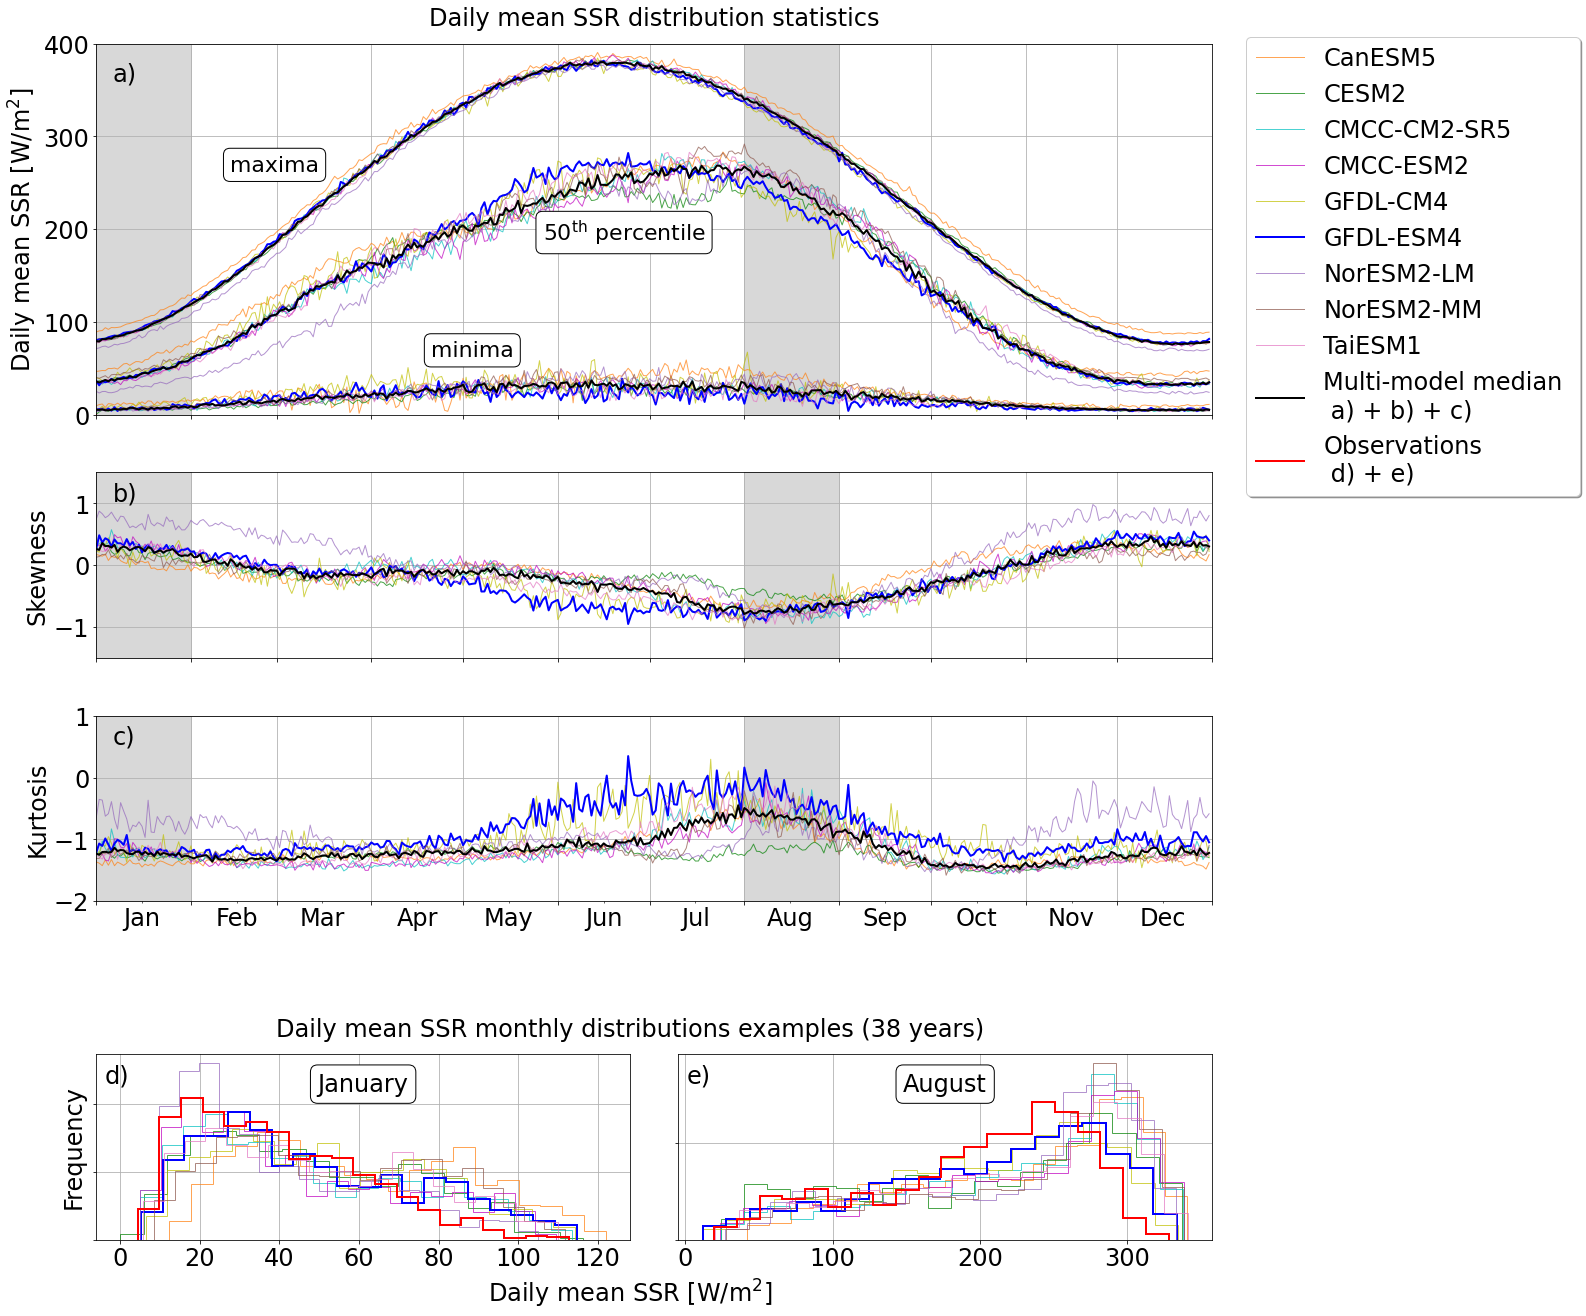

In [9]:
fig = plt.figure(figsize = (20,22))
gs  = fig.add_gridspec(nrows=5, ncols=2, height_ratios=[2, 1, 1, 0.2, 1], wspace=0.09, hspace=0.3) 

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])
ax3 = fig.add_subplot(gs[2, :])
ax4 = fig.add_subplot(gs[-1, :-1])
ax5 = fig.add_subplot(gs[-1, -1])

all_mins, all_medians, all_maxs, all_skewness, all_kurtosis = {}, {}, {}, {}, {} # To compute the multi-model median afterwards

for model_name, rsds in rsds_models.items():

    if model_name in style_dict: # To ignore the commented models in style_dict

        reshaped_rsds = my_functions.reshape(rsds)

        mins          = np.nanmin(reshaped_rsds, axis = 0)
        medians       = np.nanpercentile(reshaped_rsds, 50, axis = 0)
        maxs          = np.nanmax(reshaped_rsds, axis = 0)
        skewness      = skew(reshaped_rsds    , axis = 0)
        kurt          = kurtosis(reshaped_rsds, axis = 0)

        color, linewidth, linestyle, alpha = style_dict[model_name].values()

        ax1.plot(mins    , color = color, linestyle = linestyle, alpha = alpha, linewidth = linewidth)
        ax1.plot(medians , color = color, linestyle = linestyle, alpha = alpha, linewidth = linewidth)
        ax1.plot(maxs    , color = color, linestyle = linestyle, alpha = alpha, linewidth = linewidth, label = model_name)
        ax2.plot(skewness, color = color, linestyle = linestyle, alpha = alpha, linewidth = linewidth)
        ax3.plot(kurt    , color = color, linestyle = linestyle, alpha = alpha, linewidth = linewidth)

        # Histogram for January (Only 38 years to compare with Observations)
        ax4.hist(reshaped_rsds[0:38, 0:31].flatten()   , bins=20, density=True, histtype='step', color = color, linestyle = linestyle, alpha = alpha, linewidth = linewidth) 

        # Histogram for August (Only 38 years to compare with Observations)
        ax5.hist(reshaped_rsds[0:38, 212:243].flatten(), bins=20, density=True, histtype='step', color = color, linestyle = linestyle, alpha = alpha, linewidth = linewidth) 

        # To compute the multi-model median afterwards
        all_mins[model_name]     = mins
        all_medians[model_name]  = medians
        all_maxs[model_name]     = maxs
        all_skewness[model_name] = skewness
        all_kurtosis[model_name] = kurt

# Plot the multi-model medians 
ax1.plot(np.median(list(all_mins.values())    , axis = 0), color = 'black', linewidth = 2)
ax1.plot(np.median(list(all_medians.values()) , axis = 0), color = 'black', linewidth = 2, label = 'Multi-model median \n a) + b) + c)')
ax1.plot(np.median(list(all_maxs.values())    , axis = 0), color = 'black', linewidth = 2)
ax2.plot(np.median(list(all_skewness.values()), axis = 0), color = 'black', linewidth = 2)
ax3.plot(np.median(list(all_kurtosis.values()), axis = 0), color = 'black', linewidth = 2)

# plot the histogram for Observations if the location is Zürich
if location == 'Zurich':

    ax4.hist(reshaped_rsds_obs[:, 0:31].flatten()   , bins=20, linewidth=2, density=True, histtype='step', color = 'red') # Histogram of January
    ax5.hist(reshaped_rsds_obs[:, 212:243].flatten(), bins=20, linewidth=2, density=True, histtype='step', color = 'red') # Histogram of August

    ax1.plot([-10,0], [0, 0], linewidth=2, color = 'red', label = 'Observations\n d) + e)') # Useless plot to add the label to the legend of ax1


# plot technical parameters

ax1.legend(bbox_to_anchor=(1.02, 1.05), ncol=1, fancybox=True, shadow=True) 

ax1.set_ylim(0,400) 
ax2.set_ylim(-1.5, 1.5)
ax3.set_ylim(-2.0, 1.0)

for ax in [ax1, ax2, ax3]:

    # Add grey shading to show the months considered for the histograms
    y_min, y_max = ax.get_ylim()
    ax.fill_betweenx([y_min, y_max], 0, 31, color='gray', alpha=0.3) 
    ax.fill_betweenx([y_min, y_max], 212, 243, color='gray', alpha=0.3)

    ax.set_xlim(0,364)
    ax.set_xticks([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]) 
    ax.set_xticklabels([], rotation=45)
    ax.set_xticklabels('')
    ax.grid()   

for ax in [ax4, ax5]:
    
    ax.grid()   
    ax.set_yticklabels('')

ax3.set_xticks([15, 46, 74, 105, 135, 166, 196, 227, 258, 288, 319, 349], minor=True)
ax3.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], minor=True)
    
ax1.set_ylabel('Daily mean SSR [W/m$^2$]')
ax2.set_ylabel('Skewness')
ax3.set_ylabel('Kurtosis')
ax4.set_ylabel('Frequency')

ax1.text(0.5 ,  1.1 , 'Daily mean SSR distribution statistics', transform=ax1.transAxes, va='top', ha = 'center')
ax4.text(1.0 ,  1.2 , 'Daily mean SSR monthly distributions examples (38 years)', transform=ax4.transAxes, va='top', ha = 'center')
ax4.text(1.0 , -0.2 , 'Daily mean SSR [W/m$^2$]', ha = 'center', transform=ax4.transAxes, va='top')
ax4.text(0.5 ,  0.8 , 'January', ha = 'center', transform=ax4.transAxes, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
ax5.text(0.5 ,  0.8 , 'August' , ha = 'center', transform=ax5.transAxes, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
ax1.text(0.12,  0.7 , 'maxima', transform=ax1.transAxes, va='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), fontsize = 22)
ax1.text(0.4 ,  0.53, '$50^{\mathrm{th}}$ percentile', transform=ax1.transAxes, va='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), fontsize = 22)
ax1.text(0.3 ,  0.2 , 'minima', transform=ax1.transAxes, va='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), fontsize = 22)
ax1.text(0.015, 0.95, 'a)', transform=ax1.transAxes, va='top')
ax2.text(0.015, 0.95, 'b)', transform=ax2.transAxes, va='top')
ax3.text(0.015, 0.95, 'c)', transform=ax3.transAxes, va='top')
ax4.text(0.015, 0.95, 'd)', transform=ax4.transAxes, va='top')
ax5.text(0.015, 0.95, 'e)', transform=ax5.transAxes, va='top')

plt.savefig(f'Figures/SSR_Overview/Overview_{len(style_dict)}_models_{location}.png', bbox_inches='tight')

plt.show()

---
## Density Plots

We compare density plots (number of day falling within a $1$ day $\times$ $1$ $W/m^2$ window) of Observations and one climate model for the grid box containing Zürich.

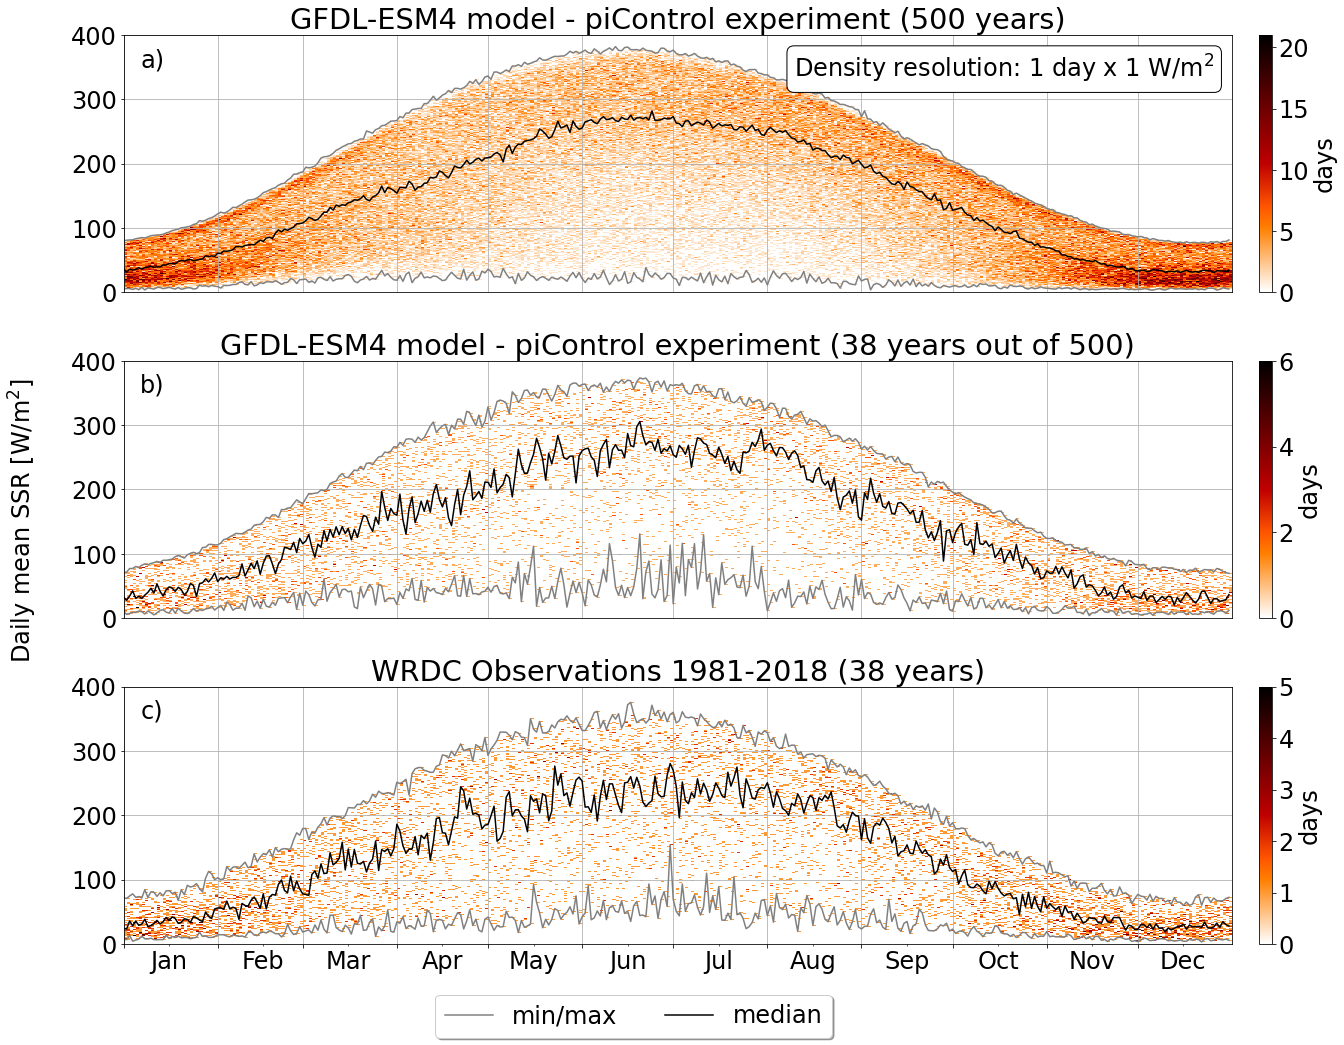

In [12]:
model_name = 'GFDL-ESM4'

rsds_models_Zurich   = pickle.load(open(f'Data/rsds/Zurich.pickle', 'rb'))
rsds_model           = rsds_models_Zurich[model_name]
n_years_model        = len(rsds_model)//365

fig = plt.figure(figsize = (20,15))
gs  = fig.add_gridspec(3,1)

for i, rsds_to_plot in enumerate([rsds_model,                   # Model Data - Full length
                                  rsds_model[0:len(rsds_obs)],  # Model Data - Same length as the Observations
                                  rsds_obs]):                   # Observations

    ax = fig.add_subplot(gs[i,0])

    reshaped_rsds = my_functions.reshape(rsds_to_plot)
    
    # Compute and plot minimum, maximum and median daily values
    medians       = np.nanpercentile(reshaped_rsds, 50, axis = 0)
    mins          = np.nanmin(reshaped_rsds, axis = 0)
    maxs          = np.nanmax(reshaped_rsds, axis = 0)

    ax.plot(maxs,    color = 'gray',  label = 'min/max')
    ax.plot(medians, color = 'black', label = 'median' )
    ax.plot(mins,    color = 'gray')


    # Compute and plot density (only daily values smaller than 400 W/m^2 considered)
    density        = np.zeros((400, 365))

    for day in range(365):
        
        for val in reshaped_rsds[:,day]:  
            if val < 400:
                density[int(val), day] += 1

    pcolormesh = ax.pcolormesh(density, cmap = 'gist_heat_r')
    colorbar = fig.colorbar(pcolormesh, ax=ax, pad=0.02, label = 'days')

    # Set plot parameters
    if i == 0:
        ax.set_title(f'{model_name} model - piControl experiment ({n_years_model} years)')
        ax.text(0.015, 0.95, 'a)', transform=ax.transAxes, va='top')

    if i == 1:
        ax.set_title(f'{model_name} model - piControl experiment ({n_years_obs} years out of {n_years_model})')
        ax.text(0.015, 0.95, 'b)', transform=ax.transAxes, va='top')

    if i == 2:
        ax.set_title(f'WRDC Observations {round(years[0])}-{round(years[-1])} ({n_years_obs} years)')
        ax.text(0.015, 0.95, 'c)', transform=ax.transAxes, va='top')

    ax.set_xticks([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]) 

    if i != 2:
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    else:
        ax.legend(bbox_to_anchor=(0.65, -0.15), ncol=2, fancybox=True, shadow=True)
        ax.set_xticklabels('')
        ax.set_xticks([15, 46, 74, 105, 135, 166, 196, 227, 258, 288, 319, 349], minor=True)
        ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], minor=True)


    if i == 0:
        ax.text(0.605, 0.93, 'Density resolution: 1 day x 1 W/m$^2$', transform=ax.transAxes, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

    ax.grid()


fig.text(-0.015, 0.5, 'Daily mean SSR [W/m$^2$]', ha='center', va='center',fontsize = 24, rotation = 'vertical')

plt.tight_layout()

plt.savefig(f'Figures/SSR_Overview/SSR_Range_{model_name}.png', bbox_inches='tight')
plt.show()